In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import plot
import calculate

#this defines the criterion which we use to filter authors
CAREER_LENGTH = 1
# this defines how long we follow each cohort
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018

num_years_in_cohort = 1

### Read authors with start and end year details

In [2]:
# authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-extended.csv')

In [3]:
print("authorStartEndCareerData: ", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData.head())

#print(authorStartEndCareerData[authorStartEndCareerData['author'] == 'donatella sciuto'])
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)

authorStartEndCareerData:  1699352


#### Career Len removal

In [4]:
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData.career_length >= CAREER_LENGTH]

In [5]:
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,early_career_degree_3,early_career_qual_3,succ_after_15y,early_career_prod_3,early_career_coauthor_max_cit_3,early_career_recognition_EC3_RC3,early_career_recognition_EC3_RC5,h-index_15,h-index_3
0,'maseka lesaoana,2001,2015,2,15,14,5.0,True,none,0.0,23.0,23.0,1,0.0,2.0,5.0,1.0,1.0
1,(max) zong-ming cheng,2009,2011,2,3,13,5.0,True,none,14.0,4.0,4.0,2,8.0,3.0,4.0,1.0,1.0
2,(zhou) bryan bai,2011,2012,2,2,14,5.0,True,none,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0
3,a aart blokhuis,1992,2005,2,14,13,5.0,True,none,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
4,a ahrabian,2017,2017,1,1,15,7.5,True,none,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0


### Read Publication data

In [6]:
authorPublicationData = pd.read_csv('derived-data/author-publications.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

print("authorPublicationData: ", authorPublicationData.shape[0])

authorPublicationData.head()

authorPublicationData:  9467149


,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [7]:
author_year_numPub.head()

,author,year,num_pub
0,'maseka lesaoana,2001,1
1,'maseka lesaoana,2015,1
2,(max) zong-ming cheng,2009,1
3,(max) zong-ming cheng,2011,1
4,(zhou) bryan bai,2011,1


In [8]:
authorPublicationData[authorPublicationData["author"] == "'maseka lesaoana"]

,author,year,pub_id
4576508,'maseka lesaoana,2015,2a10f544-51ac-4261-8a26-cf61c1abdc03
4931686,'maseka lesaoana,2001,4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa


## Publications analysis

In [9]:
author_year_numPub_sample = author_year_numPub#.head(10000)

In [10]:
author_year_numPub_with_authors = author_year_numPub_sample.merge(authorStartEndCareerData[['author','start_year', 'gender']], on="author")

groupByYearData = calculate.calculate_cumulative_for_authors(author_year_numPub_with_authors, 'num_pub')

In [11]:
years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]



In [12]:
# step = 3
# cohort_start_years = list(range(years[0], END_YEAR - MAX_CAREER_LENGTH_COHORT + step, step))
# skip_overlaping_years = False

In [13]:
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

         year            author  num_pub  start_year gender  cum_num_pub
733467   2001  'maseka lesaoana        1        2001   none            1
4142431  2015  'maseka lesaoana        1        2001   none            2
         year                 author  num_pub  start_year gender  cum_num_pub
2211746  2009  (max) zong-ming cheng        1        2009   none            1
2794612  2011  (max) zong-ming cheng        1        2009   none            2


#### Tests

In [ ]:
# from importlib import reload
# reload(plot)
# reload(calculate)

In [ ]:
# cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", authorStartEndCareerData)

# #------------------------------------------
# # some plausibility checks
# print(cohort_careerage_df.head(n=1))
# subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
#                               (cohort_careerage_df.gender == "all")]
# vals1 = subset1["values"]

# subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
#                                (cohort_careerage_df.gender == "all")]
# vals10 = subset10["values"]

# from collections import Counter

# print(type(vals1))
# print(Counter(vals1.values[0]))
# print(len(vals1.values[0]))


# print(type(vals10))
# print(Counter(vals10.values[0]))
# print(len(vals10.values[0]))


In [ ]:
# groupByYearData[groupByYearData['year'] == 2018].shape

In [ ]:
# groupByYearData[groupByYearData['year'] == 2018]['num_pub'].sum()

In [ ]:
# from plot import *

# max_career_age_cohort, criterion, criterion_display = MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications"

# print("get_cohort_careerage_df")
# cohort_careerage_df = get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData)

# print("group_cohorts")
# cohort_careerage_df = group_cohorts(cohort_careerage_df, cohort_start_years, num_years_in_cohort)

# #gini
# cohort_size_gini = get_cohort_size_gini(cohort_careerage_df,criterion, cohort_careerage_df["cohort_start_year"].unique())

# print("plot_gini")
# plot_gini(cohort_size_gini, criterion, criterion_display)

# print("plot_cohort_size_gini_cor")
# plot_cohort_size_gini_cor(cohort_size_gini,  criterion, criterion_display)

# # effect size and significance - mwu
# cohort_effect_size_df = get_cohort_effect_size(cohort_careerage_df)

# # mean/std/median
# stats = get_cohort_stats(cohort_careerage_df, criterion)
# stats = stats.merge(cohort_effect_size_df, on=['cohort_start_year', 'career_age'])
# # doesnt plot anything
# #     plot_cohort_gender_diffs(stats, criterion, criterion_display)
# print("plot_cohort_means_over_ages")
# plot_cohort_means_over_ages(stats, criterion, criterion_display)

# stats[['cohort_start_year', 'cohort_size', 'career_age', 'cliffd_m_f', 'values', 'effect', 'statistic', 'pvalue']].head()

# plot_cohort_diffs_over_ages(stats, criterion, criterion_display)

## Run cohort analysis

In [ ]:
#plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", authorStartEndCareerData, num_years_in_cohort)  

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


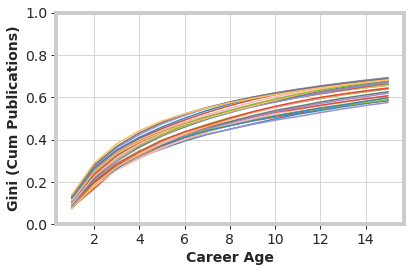

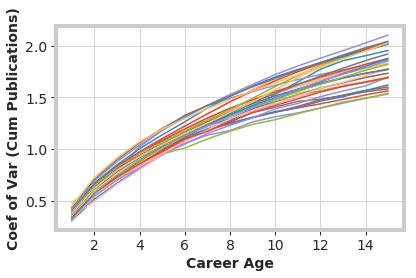

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


plot_cohort_means_over_ages


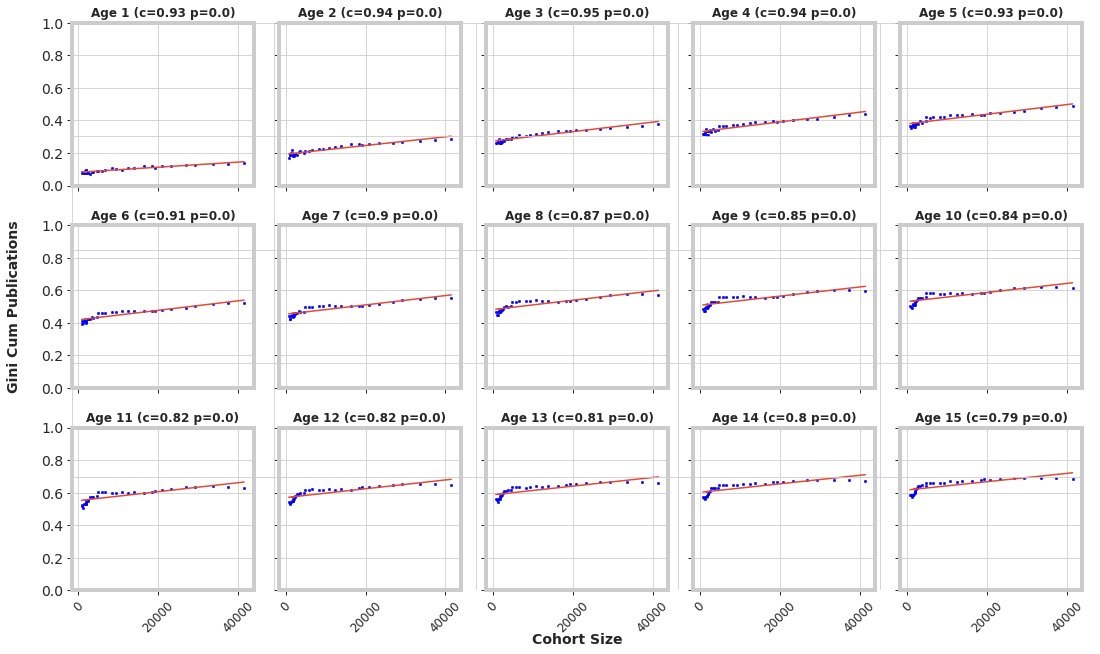

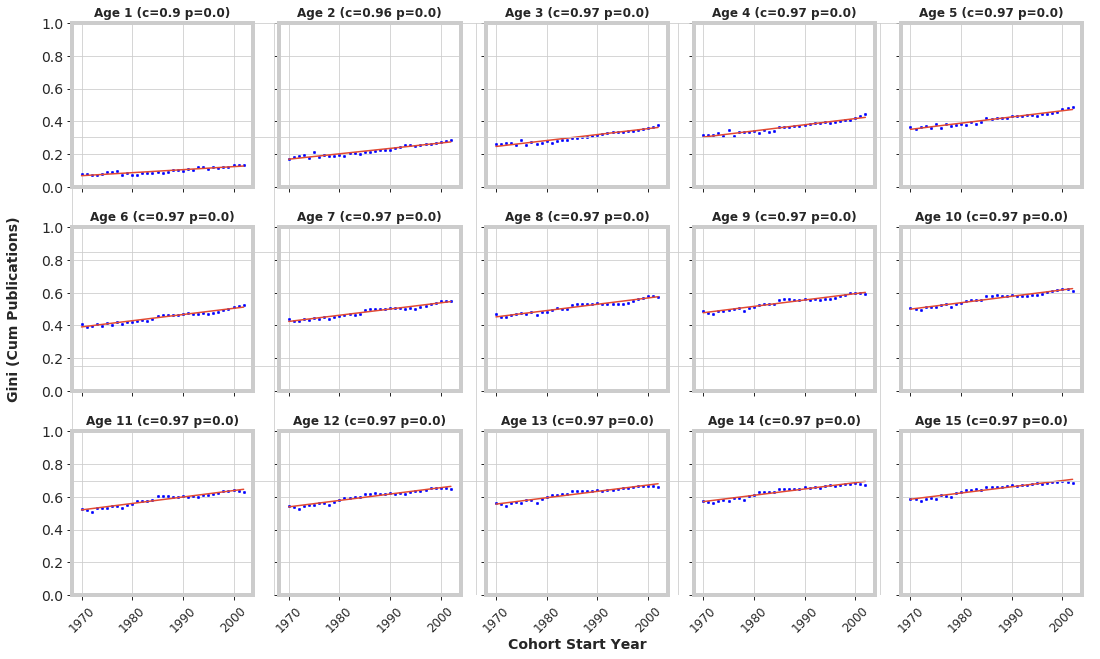

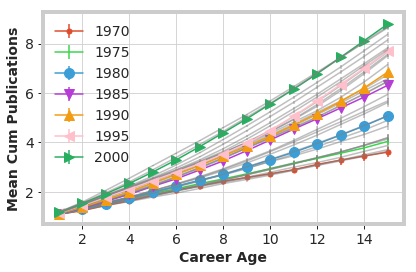

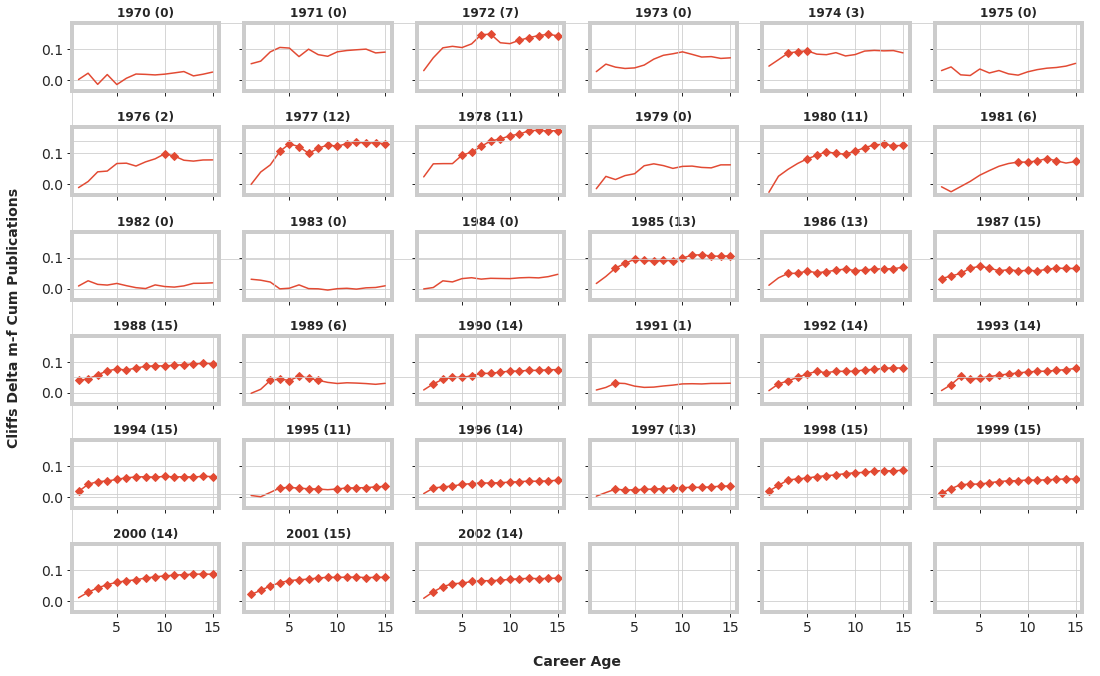

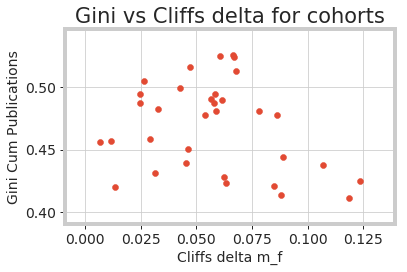

In [14]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cum Publications", authorStartEndCareerData, num_years_in_cohort)  